In [153]:
%matplotlib inline

import matplotlib.pyplot as plt
from nltk import word_tokenize, pos_tag
import pandas as pd
import numpy as np
from os import listdir
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.pipeline import Pipeline

Read in data

In [2]:
path_to_compare_data_1 = "UKPConvArg1Strict-CSV/"

files = listdir(path_to_compare_data_1)

all_data = []

for f in files:
    path = path_to_compare_data_1 + f
    one_argument = pd.read_csv(path, sep="\t")
    one_argument["argument_group"] = f
    all_data.append(one_argument)
    
X_raw = pd.concat(all_data).reset_index(drop=True)
X_raw.head()

,#id,label,a1,a2,argument_group
0,arg219237_arg219207,a2,"jesus loves plastic water bottles, and you can...",Bottled water consumption has grown exponentia...,ban-plastic-water-bottles_no-bad-for-the-econo...
1,arg219203_arg219206,a2,The American Water companies are Aquafina (Pep...,Americans spend billions on bottled water ever...,ban-plastic-water-bottles_no-bad-for-the-econo...
2,arg219225_arg219284,a1,Banning plastic bottled water would be a huge ...,God created water bottles for a reason. Becaus...,ban-plastic-water-bottles_no-bad-for-the-econo...
3,arg219216_arg219207,a2,The water bottles are a safe source of water a...,Bottled water consumption has grown exponentia...,ban-plastic-water-bottles_no-bad-for-the-econo...
4,arg219207_arg219294,a1,Bottled water consumption has grown exponentia...,"If bottled water did not exist, more people wo...",ban-plastic-water-bottles_no-bad-for-the-econo...


In [3]:
y_raw = X_raw.pop("label")
y_raw.head()

0    a2
1    a2
2    a1
3    a2
4    a1
Name: label, dtype: object

Create base dataset. Make y an integer and rename the arguments to use zero-based indexing.

In [193]:
y = (y_raw == "a2").astype(int)
X = X_raw.drop(["#id"], axis=1)
X.columns = ["a0", "a1", "argument_group"]

def sentence_tags(text):
    text = text.decode('utf-8')
    tags = pos_tag(word_tokenize(text))
    only_tags = [t[1] for t in tags]
    return " ".join(only_tags)

X["a0_tags"] = X.a0.apply(sentence_tags)
X["a1_tags"] = X.a1.apply(sentence_tags)

X.head()

,a0,a1,argument_group,a0_tags,a1_tags
0,"jesus loves plastic water bottles, and you can...",Bottled water consumption has grown exponentia...,ban-plastic-water-bottles_no-bad-for-the-econo...,"NN VBZ JJ NN NNS , CC PRP VBP JJ IN DT NN",JJ NN NN VBZ VBN RB IN DT JJ NN TO VB NNS . DT...
1,The American Water companies are Aquafina (Pep...,Americans spend billions on bottled water ever...,ban-plastic-water-bottles_no-bad-for-the-econo...,"DT JJ NNP NNS VBP NNP ( NNP ) , NNP ( NNP ) , ...",NNPS VBP NNS IN JJ NN DT NN . NNP PRP$ NN MD R...
2,Banning plastic bottled water would be a huge ...,God created water bottles for a reason. Becaus...,ban-plastic-water-bottles_no-bad-for-the-econo...,NNP NN VBD NN MD VB DT JJ NN IN DT RB NN . JJR...,NNP VBD NN NNS IN DT NN . IN PRP$ JJ .
3,The water bottles are a safe source of water a...,Bottled water consumption has grown exponentia...,ban-plastic-water-bottles_no-bad-for-the-econo...,DT NN NNS VBP DT JJ NN IN NN CC VBZ JJ NN,JJ NN NN VBZ VBN RB IN DT JJ NN TO VB NNS . DT...
4,Bottled water consumption has grown exponentia...,"If bottled water did not exist, more people wo...",ban-plastic-water-bottles_no-bad-for-the-econo...,JJ NN NN VBZ VBN RB IN DT JJ NN TO VB NNS . DT...,"IN VBN NN VBD RB VB , JJR NNS MD VB VBG JJ NNS..."


In [152]:
y.head()

0    1
1    1
2    0
3    1
4    0
Name: label, dtype: int64

Build a benchmark model as fast as possible.

In [217]:
transition_words = set(['similarly', 'foremost', 'presumably', 'moreover', 'however', 'reason', 'otherwise', 'second,', 'still', 'first', 'even', 'ultimately', 'finally', 'therefore', 'addition', 'next', 'also', 'furthermore', 'conclusion', 'third', 'hand', 'another'])
misspelled_words = set(['wouldn', 'dont', 'shouldn', 'india', 'firefox', 'didn', 'wouldnt', 'doesnt', 'thier', 'farquhar', 'couldn', 'commited', 'adam', 'theyre', 'sabrejimmy', 'persuit', 'definately', 'shouldnt', 'marrage', 'syona', 'alot', 'beleive', 'donot', 'commen', 'especialy', 'dicipline', 'arguement', 'likley', 'lously', 'havn', 'alcohlic', 'wasnt', 'aint', 'bcoz', 'hace', 'decir', 'planta', 'politian', 'acomplice', 'definetly', 'incestual', 'chasbas', 'soooo', 'coolio', 'hoolio', 'infront', 'creatoinism', 'enviroment', 'hasn', 'becasue', 'farquer', 'xada', 'atrever', 'menos', 'dathu', 'ihfej', 'humano', 'charector', 'blimem', 'shld', 'urself', 'tijkjdrk', 'sholud', 'jarman', 'responsibilily', 'preverted', 'plantas', 'aunque', 'sayin', 'xadgeno', 'imformation', 'xbanico', 'sfjiiytg', 'negleted', 'chupar', 'guil', 'xtklp', 'incharge', 'telvisions', 'telivision', 'igual', 'recursos', 'ushould', 'thik', 'supress', 'querido', 'idioma', 'unforms', 'unatrel', 'cauntious', 'evrybdy', 'bookxx', 'beleifs', 'eles', 'completly', 'isnot', 'beleave', 'beter', 'llaman', 'wdout', 'smoken', 'facr', 'illegaly', 'nowadayz', 'doont', 'somkers', 'somke', 'responsiblity', 'homosapien', 'dissappointed', 'criterium', 'hets', 'doughter', 'posible', 'strategizing', 'succeful', 'probaly', 'atleast', 'beileve', 'vida', 'pero', 'mench', 'playstations', 'niega', 'importhant', 'pensar', 'sentir', 'puede', 'aslong', 'ciggarettes', 'sooooooo', 'ebil', 'sito', 'botherd', 'diegnosedca', 'humanos', 'animales', 'suelen', 'aborto', 'matar', 'bullsh', 'employe', 'evryone', 'benifit', 'enviorment', 'lookin', 'persue', 'diffenrent', 'embroyo', 'undertsand', 'interveiw', 'becouse', 'afterschool', 'diferent', 'highschool', 'alreaddy', 'leagal', 'unpetty', 'themselfs', 'yoursel', 'defenceless', 'absolutley', 'peices', 'advencing', 'isnt', 'inequal', 'instinc', 'succesful', 'insctinc', 'disapointment', 'organisation', 'beemed', 'succeded', 'woulld', 'excuss', 'chil', 'singapura', 'majulah', 'mothernature', 'wannna', 'compulsaryy', 'preggo', 'weren', 'dieases', 'relize', 'coloured', 'actualy', 'expirience', 'itll', 'obecity', 'personhood', 'dosent', 'clases', 'mandortory', 'excersise', 'whloe', 'manditory', 'howzz', 'definatley', 'expirence', 'benifits', 'licence', 'echoworld', 'lieing', 'othr', 'alow', 'overal', 'theri', 'stoping', 'selfes', 'becoz', 'mmorning', 'mustn', 'espeacilly', 'perfomed', 'exersises', 'thankyou', 'dreamt', 'theirself', 'cuhz', 'learnt', 'malay', 'proble', 'wether', 'newscientist', 'evealution', 'makind', 'beleivers', 'argumentum', 'populum', 'extreamly', 'callad', 'beleives', 'scientologists', 'aquire', 'existance', 'addons', 'fanboy', 'realeased', 'wayyyyy', 'pointlessss', 'enititys', 'microsot', 'stylesheets', 'google', 'toolbar', 'phro', 'tohttp', 'evol', 'dinosauria', 'neccisary', 'varifiable', 'usgs', 'envirnment', 'nuff', 'polandspring', 'aspx', 'duboard', 'criters', 'worryz', 'excrament', 'produceing', 'evironment', 'poluted', 'healthywater', 'hypocryte', 'friendsjournal', 'garentee', 'compostable', 'youre', 'serval', 'comfortabley', 'suply', 'nikawater', 'nestlewaterscorporate', 'equis', 'ditrabutions', 'treehugger', 'extremly', 'weve', 'aynrandlexicon', 'flipppin', 'belivers', 'religon', 'biggots', 'athieists', 'besause', 'indepent', 'healp', 'lawl', 'sunday', 'spamming', 'therfore', 'recognise', 'simplier', 'didnt', 'xafsm', 'disputs', 'superbrain', 'politians', 'hitech', 'illitrate', 'literated', 'enought', 'specialy', 'fricken', 'opressed', 'illeteracy', 'toughy', 'somone', 'muder', 'marrie', 'sombody', 'accompalice', 'incase', 'hurst', 'basicly', 'preffer', 'nothong', 'tounges', 'contries', 'forgeting', 'ndians', 'hardwork', 'languags', 'utillised', 'prsns', 'ptential', 'manufactoring', 'dependant', 'alawys', 'violance', 'dissapointed', 'tought', 'figuer', 'msitake', 'arent', 'ooooooooh', 'sush', 'differnce', 'wats', 'aryabhatta', 'chatng', 'debatng', 'partical', 'pottential', 'nuissance', 'nalanda', 'jagah', 'achcha', 'hamara', 'britishers', 'orginal', 'americans', 'rama', 'krishna', 'vishvamitr', 'vishvguru', 'francisco', 'nutjobes', 'certainley', 'needn', 'roomates', 'marraige', 'secuality', 'respecful', 'harrassed', 'veiws', 'centry', 'commiting', 'beacuse', 'adware', 'nobrob', 'enuff', 'preinstall', 'derrrr', 'imho', 'weatherfox', 'apps', 'novanet', 'perfrom', 'popup', 'avaible', 'tooltip', 'spaking', 'saame', 'butthole', 'belifs', 'eachother', 'hackman', 'involed', 'throught', 'defence', 'worng', 'couldnt', 'reponsiblity', 'wong', 'woppen', 'nessasary', 'prenup', 'becuase', 'liklihood', 'couse', 'contriverse', 'accomodate', 'extrem', 'pepole', 'accomodations', 'sucied', 'wakoness', 'absoultly'])
slang_words = set(['creep', 'jerk', 'basic', 'wicked', 'diss', 'props', 'unreal', 'dig', 'ripped', 'swole', 'wrecked', 'wasted', 'busted', 'awesome', 'trip', 'cool', 'chilling', 'chill', 'amped', 'blast', 'crush', 'dump', 'geek', 'sick', 'toasted', 'fail', 'epic', 'dunno', 'loser', 'rip', 'off', 'beat', 'bling', 'break', 'cheesy', 'cop', 'out', 'da', 'bomb', 'dope', 'downer', 'fab', 'flake', 'freak', 'disgusting', 'hooked', 'fleet', 'flawless', 'snatched', 'shorty', 'grill', 'hustle', 'grind', 'beef', 'fresh', 'word', 'wack', 'def', 'skeeze', 'ill', 'dough', 'mooch', 'boo', 'baller', 'bromance', 'dawg', 'dude', 'lol', 'ratchet', 'selfie', 'sweet', 'woke', 'neat', 'kidding', 'agame', 'bro', 'cash', 'cop', 'hip', 'jacked', 'hype', 'score', 'trash', 'riled', 'pissed', 'bummer', 'check', 'dead', 'totes'])
important_parts_of_speech = ["vbp", "vbp prp", "nn nn", "to", "dt", "dt nn", "cc"]


def n_general_transitions(x):
    words = x.split()
    total = 0
    for w in words:
        if w in transition_words:
            total += 1
    return total


def n_misspelled_words(x):
    words = x.split()
    total = 0
    for w in words:
        if w in misspelled_words:
            total += 1
    return total


def n_slang_words(x):
    words = x.split()
    total = 0
    for w in words:
        if w in slang_words:
            total += 1
    return total

def percent_unique(x):
    words = x.split()
    unique = set(words)
    percent_unique = len(unique)/len(words)
    return percent_unique


class TextBasedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        a0_raw = X.a0
        a1_raw = X.a1
        a0_simple = a0_raw.str.lower().str.replace("[^a-zA-Z ]", "")
        a1_simple = a1_raw.str.lower().str.replace("[^a-zA-Z ]", "")
        a0 = a0_simple.str
        a1 = a1_simple.str
        
        # a0 features
        X["characters_a0"] = a0.len()
        X["pronoun_counts_a0"] = a0.count(" you ") + a0.count(" i ") + a0.count(" me ") + a0.count(" my ")
        X["certain_lang_counts_a0"] = a0.count(" always ") + a0.count(" never ") + a0.count(" impossible ")
        X["uncertain_lang_counts_a0"] = a0.count(" believe ") + a0.count(" think ") + a0.count(" feel ")
        X["bold_counts_a0"] = a0_raw.str.count("<br/>")
        X["because_counts_a0"] = a0_raw.str.count("because")
        X["quote_counts_a0"] = a0_raw.str.count("[\"']")
        X["comma_counts_a0"] = a0_raw.str.count(",")
        X["words_a0"] = a0.count(" ") + 1
        X["total_punctuation_a0"] = a0_raw.str.count("[.,?$!:;'\"-]")
        X["punctuation_percent_a0"] = X["total_punctuation_a0"]/X["characters_a0"]
        X["end_of_sentence_punct_counts_a0"] = a0_raw.str.count("[!?.][ \n]")
        X["no_sentence_punctuation_a0"] = (X["end_of_sentence_punct_counts_a0"]==0).astype(int)
        X["sentence_counts_a0"] = X["end_of_sentence_punct_counts_a0"] + X["no_sentence_punctuation_a0"]
        X["average_sentence_word_len_a0"] = X["words_a0"]/X["sentence_counts_a0"]
        X["average_sentence_char_len_a0"] = X["characters_a0"]/X["sentence_counts_a0"]
        X["average_word_length_a0"] = X["characters_a0"]/X["words_a0"]
        X["n_transitions_a0"] = a0_simple.apply(n_general_transitions)
        X["n_misspelled_a0"] = a0_simple.apply(n_misspelled_words)
        X["n_slang_words_a0"] = a0_simple.apply(n_slang_words)
        X["percent_words_unique_a0"] = a0_simple.apply(percent_unique)
        X["first_word_capitalized_a0"] = a0_raw.apply(lambda x: x[0].isupper()*1)
        X["n_proper_nouns_a0"] = a0_raw.str.count("[^.!?;] [A-Z]")
        X["all_caps_words_a0"] = a0_raw.str.count("[A-Z]+[ .!?]")
        X["n_digits_a0"] = a0_raw.apply(lambda x: sum(1 for c in x if c.isdigit()))
        X["n_links_a0"] = a0_raw.str.count("http")
        X["vbp_a0"] = X.a0_tags.str.count("VBP")
        X["vbp_prp_a0"] = X.a0_tags.str.count("VBP PRP")
        X["nn_nn_a0"] = X.a0_tags.str.count("NN NN")
        X["to_a0"] = X.a0_tags.str.count("TO")
        X["dt_a0"] = X.a0_tags.str.count("DT")
        X["dt_nn_a0"] = X.a0_tags.str.count("DT NN")
        X["cc_a0"] = X.a0_tags.str.count("CC")
        
        # a1 features
        X["characters_a1"] = a1.len()
        X["pronoun_counts_a1"] = a1.count(" you ") + a1.count(" i ") + a1.count(" me ") + a1.count(" my ")
        X["certain_lang_counts_a1"] = a1.count(" always ") + a1.count(" never ") + a1.count(" impossible ")
        X["uncertain_lang_counts_a1"] = a1.count(" believe ") + a1.count(" think ") + a1.count(" feel ")
        X["bold_counts_a1"] = a1_raw.str.count("<br/>")
        X["because_counts_a1"] = a1_raw.str.count("because")
        X["quote_counts_a1"] = a1_raw.str.count("[\"']")
        X["comma_counts_a1"] = a1_raw.str.count(",")
        X["words_a1"] = a1.count(" ") + 1
        X["total_punctuation_a1"] = a1_raw.str.count("[.,?$!:;'\"-]")
        X["punctuation_percent_a1"] = X["total_punctuation_a1"]/X["characters_a1"]
        X["end_of_sentence_punct_counts_a1"] = a1_raw.str.count("[!?.][ \n]")
        X["no_sentence_punctuation_a1"] = (X["end_of_sentence_punct_counts_a1"]==0).astype(int)
        X["sentence_counts_a1"] = X["end_of_sentence_punct_counts_a1"] + X["no_sentence_punctuation_a1"]
        X["average_sentence_word_len_a1"] = X["words_a1"]/X["sentence_counts_a1"]
        X["average_sentence_char_len_a1"] = X["characters_a1"]/X["sentence_counts_a1"]
        X["average_word_length_a1"] = X["characters_a1"]/X["words_a1"]
        X["n_transitions_a1"] = a1_simple.apply(n_general_transitions)
        X["n_misspelled_a1"] = a1_simple.apply(n_misspelled_words)
        X["n_slang_words_a1"] = a1_simple.apply(n_slang_words)
        X["percent_words_unique_a1"] = a1_simple.apply(percent_unique)
        X["first_word_capitalized_a1"] = a1_raw.apply(lambda x: x[0].isupper()*1)
        X["n_proper_nouns_a1"] = a1_raw.str.count("[^.!?;] [A-Z]")
        X["all_caps_words_a1"] = a1_raw.str.count("[A-Z]+[ .!?]")
        X["n_digits_a1"] = a1_raw.apply(lambda x: sum(1 for c in x if c.isdigit()))
        X["n_links_a1"] = a1_raw.str.count("http")
        X["vbp_a1"] = X.a1_tags.str.count("VBP")
        X["vbp_prp_a1"] = X.a1_tags.str.count("VBP PRP")
        X["nn_nn_a1"] = X.a1_tags.str.count("NN NN")
        X["to_a1"] = X.a1_tags.str.count("TO")
        X["dt_a1"] = X.a1_tags.str.count("DT")
        X["dt_nn_a1"] = X.a1_tags.str.count("DT NN")
        X["cc_a1"] = X.a1_tags.str.count("CC")
        
        # diff features
        X["character_diff"] = X["characters_a0"] - X["characters_a1"]
        X["character_diff_percent"] = X["character_diff"]/X["characters_a1"]
        X["pronoun_count_diff"] = X["pronoun_counts_a0"] - X["pronoun_counts_a1"]
        X["certain_language_diff"] = X["certain_lang_counts_a0"] - X["certain_lang_counts_a1"]
        X["uncertain_language_diff"] = X["uncertain_lang_counts_a0"] - X["uncertain_lang_counts_a1"]
        X["bold_counts_diff"] = X["bold_counts_a0"] - X["bold_counts_a1"]
        X["because_counts_diff"] = X["because_counts_a0"] - X["because_counts_a1"]
        X["quote_counts_diff"] = X["quote_counts_a0"] - X["quote_counts_a1"]
        X["comma_counts_diff"] = X["comma_counts_a0"] - X["comma_counts_a1"]
        X["words_diff"] = X["words_a0"] - X["words_a1"]
        X["words_diff_percent"] = X["words_diff"]/X["words_a1"]
        X["punctuation_percent_diff"] = X["punctuation_percent_a0"] - X["punctuation_percent_a1"]
        X["punctuation_percent_diff_percent"] = X["punctuation_percent_diff"]/(X["punctuation_percent_a1"] + 1)
        X["no_sentence_punctuation_diff"] = X["no_sentence_punctuation_a0"] - X["no_sentence_punctuation_a1"]
        X["sentence_diff"] = X["sentence_counts_a0"] - X["sentence_counts_a1"]
        X["average_sentence_word_len_diff"] = X["average_sentence_word_len_a0"] - X["average_sentence_word_len_a1"]
        X["average_sentence_char_len_diff"] = X["average_sentence_char_len_a0"] - X["average_sentence_char_len_a1"]
        X["average_word_length_diff"] = X["average_word_length_a0"] - X["average_word_length_a1"]
        X["average_word_length_diff_percent"] = X["average_word_length_diff"]/X["average_word_length_a1"]
        X["n_transitions_diff"] = X["n_transitions_a0"] - X["n_transitions_a1"]
        X["n_misspelled_diff"] = X["n_misspelled_a0"] - X["n_misspelled_a1"]
        X["n_slang_diff"] = X["n_slang_words_a0"] - X["n_slang_words_a1"]
        X["percent_words_unique_diff"] = X["percent_words_unique_a0"] - X["percent_words_unique_a1"]
        X["first_word_cap_diff"] = X["first_word_capitalized_a0"] - X["first_word_capitalized_a1"]
        X["n_proper_nouns_diff"] = X["n_proper_nouns_a0"] - X["n_proper_nouns_a1"]
        X["all_caps_words_diff"] = X["all_caps_words_a0"] - X["all_caps_words_a1"]
        X["n_digits_diff"] = X["n_digits_a0"] - X["n_digits_a1"]
        X["n_links_diff"] = X["n_links_a0"] - X["n_links_a1"]
        X["vbp_diff"] = X["vbp_a0"] - X["vbp_a1"]
        X["vbp_prp_diff"] = X["vbp_prp_a0"] - X["vbp_prp_a1"]
        X["nn_nn_diff"] = X["nn_nn_a0"] - X["nn_nn_a1"]
        X["to_diff"] = X["to_a0"] - X["to_a1"]
        X["dt_diff"] = X["dt_a0"] - X["dt_a1"]
        X["dt_nn_diff"] = X["dt_nn_a0"] - X["dt_nn_a1"]
        X["cc_diff"] = X["cc_a0"] - X["cc_a1"]       
        return X

    
class KeepNumeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.numeric_columns = X.dtypes[X.dtypes != "object"].index.tolist()
        return self
        
    def transform(self, X, y=None):
        return X[self.numeric_columns]

    
class OnlyDiffs(BaseEstimator, TransformerMixin):
    def __init__(self, on=True):
        self.on = on
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.on:
            diff_cols = [c for c in X.columns if "diff" in c]
            other_cols = ["a0_tags", "a1_tags"]
            return X[diff_cols+other_cols]
        else:
            return X
    

class ColNames(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.columns = X.columns
        return self
    
    def transform(self, X):
        return X

In [218]:
group_cv = LeaveOneGroupOut()
group_cv.get_n_splits(X, y, X.argument_group)

32

In [219]:
%%time
model = RandomForestClassifier(n_estimators=100,
                               n_jobs=-1,
                               random_state=42)

steps = [("simple_features", TextBasedFeatures()),
         ("only_diff_columns", OnlyDiffs(on=True)),
         ("keep_numeric_only", KeepNumeric()),
         ("col_names", ColNames()),
         ("model", model)]

pipe = Pipeline(steps)

scores = cross_val_score(pipe, X, y, cv=group_cv, groups=X.argument_group, scoring="accuracy", n_jobs=-1)

CPU times: user 1.78 s, sys: 460 ms, total: 2.24 s
Wall time: 1min 14s


In [226]:
%%time

steps = [("simple_features", TextBasedFeatures()),
         ("only_diff_columns", OnlyDiffs(on=True)),
         ("keep_numeric_only", KeepNumeric()),
         ("col_names", ColNames())]

pipe = Pipeline(steps)

X_clean = pipe.fit_transform(X, y)

CPU times: user 1.98 s, sys: 20 ms, total: 2 s
Wall time: 2.02 s


In [220]:
print("Average: %.4f +/- %.2f" % (scores.mean(), scores.std()*1.96))
print("Scores:", scores)

Average: 0.7959 +/- 0.11
('Scores:', array([ 0.86458333,  0.915     ,  0.80733945,  0.72030651,  0.86797753,
        0.69014085,  0.8164557 ,  0.81751825,  0.77475248,  0.85011186,
        0.85326087,  0.81952663,  0.71260997,  0.79190751,  0.776     ,
        0.76733781,  0.79094077,  0.74772036,  0.80758017,  0.86842105,
        0.77904328,  0.7904328 ,  0.73087071,  0.68926554,  0.69014085,
        0.83054893,  0.81132075,  0.82022472,  0.79182156,  0.81171548,
        0.80760626,  0.85522788]))


In [221]:
pipe.fit(X, y)

Pipeline(steps=[('simple_features', TextBasedFeatures()), ('only_diff_columns', OnlyDiffs(on=True)), ('keep_numeric_only', KeepNumeric()), ('col_names', ColNames()), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf...imators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])

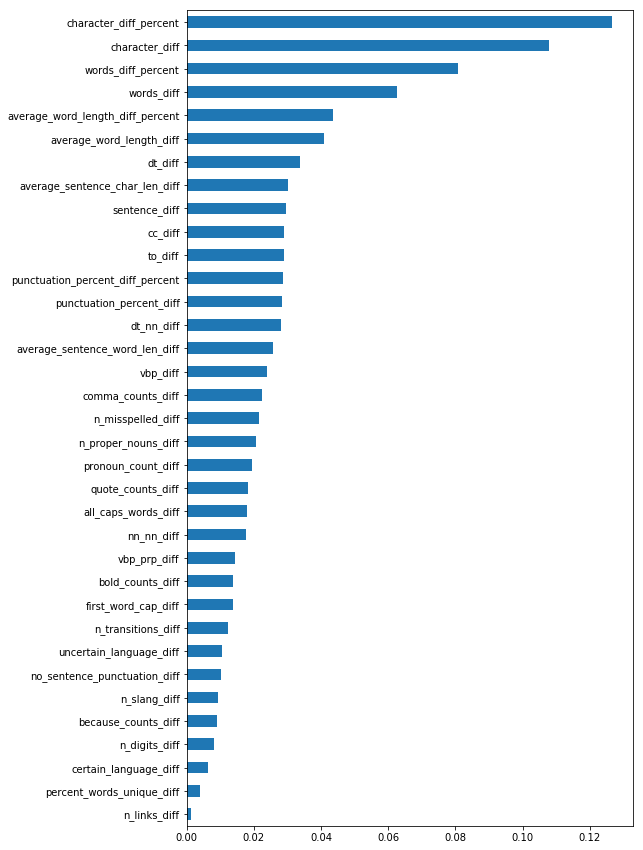

In [222]:
importances = pipe.named_steps["model"].feature_importances_
columns = pipe.named_steps["col_names"].columns

pd.Series(importances, index=columns).sort_values().plot(kind="barh", figsize=(8,15))

In [82]:
all_words = " ".join(X.a0.unique().tolist())

In [ ]:
imp

In [140]:
temp = X.a0[2]
temp

'Banning plastic bottled water would be a huge mistake in this very moment. More than a million people in the United States purchase bottled water every day which is helping the economy com out of this recession we are in. maybe not in a big way but every kid of help counts! Bottled water also only makes less then 1&#xof; the worlds wastes and can be recycled! According to the National Association for PET Container resources, PET water bottles are no the most recycled container in curb side programs by weight and by number! <br/> http://www.nestlewaterscorporate.com/bottled_water_things_to_know/Video/index.html?@videoList.featured=31101711001'

In [160]:
tags = X.a0_tags.unique()

In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [187]:
class TFIDF(BaseEstimator, TransformerMixin):
    def __init__(self, min_df=100):
        self.min_df = min_df
        
    def fit(self, X, y=None):
        tags = X.a0_tags.unique()
        self.tfidf = TfidfVectorizer(ngram_range=(1,15), 
                                     min_df=self.min_df)
        self.tfidf.fit(tags)
        return self
    
    def transform(self, X, y=None):
        a0_vectors = self.tfidf.transform(X.a0_tags).todense()
        a1_vectors = self.tfidf.transform(X.a1_tags).todense()
        diffs = a0_vectors - a1_vectors
        columns = ["tf"+str(i) for i in range(diffs.shape[1])]
        vectors = pd.DataFrame(data=diffs, columns=columns, index=X.index)
        new_data = pd.concat([X, vectors], axis=1)
        return new_data

In [180]:
tf = TfidfVectorizer(ngram_range=(1,15), 
                                  min_df=100)
tf.fit(tags)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=100,
        ngram_range=(1, 15), norm=u'l2', preprocessor=None,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None)

In [185]:
a0_vectors = tf.transform(X.a0_tags).todense()
a1_vectors = tf.transform(X.a1_tags).todense()
diffs = a0_vectors - a1_vectors

In [ ]:
columns = ["tf"+str(i) for i in range(len(X))]

In [186]:
diffs.shape

(11650, 199)

In [189]:
%%time
tf = TFIDF().fit_transform(X)

CPU times: user 19.7 s, sys: 50 ms, total: 19.8 s
Wall time: 19.8 s


In [ ]:
tf

In [176]:
tfidf.vocabulary_

{u'cc': 0,
 u'cc dt': 1,
 u'cc in': 2,
 u'cc jj': 3,
 u'cc nn': 4,
 u'cc prp': 5,
 u'cc rb': 6,
 u'cc vb': 7,
 u'cd': 8,
 u'dt': 9,
 u'dt jj': 10,
 u'dt jj nn': 11,
 u'dt jj nn in': 12,
 u'dt nn': 13,
 u'dt nn cc': 14,
 u'dt nn in': 15,
 u'dt nn in dt': 16,
 u'dt nn in nn': 17,
 u'dt nn nn': 18,
 u'dt nn prp': 19,
 u'dt nn to': 20,
 u'dt nn vbz': 21,
 u'dt nns': 22,
 u'dt vbz': 23,
 u'ex': 24,
 u'in': 25,
 u'in dt': 26,
 u'in dt jj': 27,
 u'in dt jj nn': 28,
 u'in dt nn': 29,
 u'in dt nn in': 30,
 u'in dt nns': 31,
 u'in in': 32,
 u'in jj': 33,
 u'in jj nn': 34,
 u'in nn': 35,
 u'in nn cc': 36,
 u'in nn in': 37,
 u'in nnp': 38,
 u'in nns': 39,
 u'in prp': 40,
 u'in prp md': 41,
 u'in prp nn': 42,
 u'in prp vbp': 43,
 u'in prp vbz': 44,
 u'in vbg': 45,
 u'jj': 46,
 u'jj cc': 47,
 u'jj in': 48,
 u'jj jj': 49,
 u'jj nn': 50,
 u'jj nn cc': 51,
 u'jj nn in': 52,
 u'jj nn nn': 53,
 u'jj nn prp': 54,
 u'jj nn vbz': 55,
 u'jj nnp': 56,
 u'jj nns': 57,
 u'jj nns in': 58,
 u'jj prp': 59,
 u'jj t

In [ ]:
!pip install nltk
!nltk.download('punkt')
!nltk.download('averaged_perceptron_tagger')